In [1]:
% load_ext autoreload
% autoreload 2
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os, sys

opj = os.path.join
from tqdm import tqdm

from ex_mnist import p
from dset import get_dataloader

sys.path.append('../../src/models')
from models import CNN, FFN

In [9]:
# load data
train_loader, test_loader = get_dataloader(p.data_path,
                                           batch_size=p.batch_size)

# import models
cnn = CNN().to(device)
ffn = FFN().to(device)

# train cnn

In [10]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 50

train_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.
    for batch_idx, (data, y) in enumerate(train_loader):
        data = data.to(device)
        y = y.to(device)
        # zero grad
        optimizer.zero_grad()
        output = cnn(data)
        loss = criterion(output, y)

        # backward
        loss.backward()
        # update step
        optimizer.step()

        iter_loss = loss.item()
        epoch_loss += iter_loss

        print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
                   100. * batch_idx / len(train_loader), iter_loss), end='')

    mean_epoch_loss = epoch_loss / (batch_idx + 1)
    train_losses.append(mean_epoch_loss)

# save model
torch.save(cnn.state_dict(), opj(p.model_path, 'CNN.pth'))


Train Epoch: 49 [59900/60000 (100%)]	Loss: 0.004418

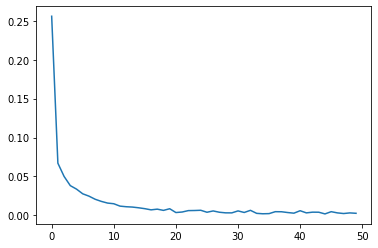

In [11]:
plt.plot(train_losses)

# train ffn

In [12]:
optimizer = torch.optim.Adam(ffn.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 50

train_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.
    for batch_idx, (data, y) in enumerate(train_loader):
        data = data.to(device)
        y = y.to(device)
        # zero grad
        optimizer.zero_grad()
        output = ffn(data)
        loss = criterion(output, y)

        # backward
        loss.backward()
        # update step
        optimizer.step()

        iter_loss = loss.item()
        epoch_loss += iter_loss

        print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
                   100. * batch_idx / len(train_loader), iter_loss), end='')

    mean_epoch_loss = epoch_loss / (batch_idx + 1)
    train_losses.append(mean_epoch_loss)

# save model
torch.save(ffn.state_dict(), opj(p.model_path, 'FFN.pth'))


Train Epoch: 49 [59900/60000 (100%)]	Loss: 0.000006

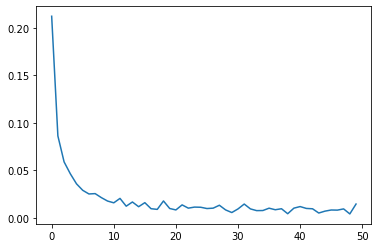

In [13]:
plt.plot(train_losses)

# model prediction

In [36]:
# check prediction
m = len(test_loader.dataset)
batch_size = test_loader.batch_size

y_pred_cnn = np.zeros(m)
y_pred_ffn = np.zeros(m)
y_true = np.zeros(m)
with torch.no_grad():
    for batch_idx, (data, y) in tqdm(enumerate(test_loader, 0), total=int(np.ceil(m / batch_size))):
        data = data.to(device)
        # cnn prediction
        outputs_cnn = cnn(data)
        _, y_pred = torch.max(outputs_cnn.data, 1)
        y_pred_cnn[batch_idx * batch_size:(batch_idx + 1) * batch_size] = y_pred.cpu().numpy()

        # ffn prediction
        outputs_ffn = ffn(data)
        _, y_pred = torch.max(outputs_ffn.data, 1)
        y_pred_ffn[batch_idx * batch_size:(batch_idx + 1) * batch_size] = y_pred.cpu().numpy()

        # labels
        y_true[batch_idx * batch_size:(batch_idx + 1) * batch_size] = y.numpy()

print("CNN accuracy {:.5f}% FFN accuracy {:.5f}%".format((y_true == y_pred_cnn).sum() / m * 100,
                                                         (y_true == y_pred_ffn).sum() / m * 100))

100%|██████████| 100/100 [00:02<00:00, 33.85it/s]

CNN accuracy 99.09000% FFN accuracy 98.28000%
